In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,TfidfTransformer
import warnings 
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import time
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from tqdm import tqdm
from sklearn.metrics import accuracy_score,confusion_matrix


In [2]:
data=pd.read_csv("preprocessed_file.csv")
data.isnull().any()

Time          False
clean text     True
Score         False
dtype: bool

In [3]:
final_data=data.dropna()
final_data.isnull().any().sum()

0

In [4]:
final_data.head(2)

,Time,clean text,Score
0,939340800,witty little book makes son laugh loud recite ...,1
1,1194739200,grew reading sendak books watching really rosi...,1


In [5]:
text=final_data["clean text"]

In [6]:
sample_data=final_data.sample(100000,random_state=42)

In [7]:
text=sample_data["clean text"]

In [8]:
print(len(text))

100000


In [9]:
i=0
list_of_sentance=[]
for sentance in text:
    list_of_sentance.append(sentance.split())

In [10]:
is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('fantastic', 0.8072654604911804), ('awesome', 0.8066225051879883), ('excellent', 0.7999838590621948), ('good', 0.7868425846099854), ('terrific', 0.7852028608322144), ('wonderful', 0.7475936412811279), ('fabulous', 0.6733604073524475), ('amazing', 0.6380982995033264), ('nice', 0.6318499445915222), ('incredible', 0.6205127239227295)]
[('greatest', 0.7437464594841003), ('nastiest', 0.7114289402961731), ('best', 0.6961050629615784), ('smoothest', 0.6398966312408447), ('tastiest', 0.6265688538551331), ('horrible', 0.6128831505775452), ('disgusting', 0.591832160949707), ('sweetest', 0.5710831880569458), ('ive', 0.5537452101707458), ('grossest', 0.5479790568351746)]


In [11]:
w2v_words = list(w2v_model.wv.key_to_index)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  19000
sample words  ['not', 'like', 'good', 'great', 'one', 'taste', 'product', 'would', 'coffee', 'flavor', 'tea', 'love', 'no', 'get', 'food', 'really', 'amazon', 'use', 'much', 'also', 'time', 'little', 'find', 'best', 'price', 'buy', 'make', 'well', 'tried', 'even', 'better', 'try', 'chocolate', 'eat', 'sugar', 'first', 'water', 'used', 'could', 'found', 'sweet', 'made', 'bag', 'bought', 'free', 'drink', 'cup', 'dog', 'box', 'way']


In [12]:
len(w2v_words)

19000

In [13]:
len(list_of_sentance)

100000

In [14]:
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [04:10<00:00, 398.86it/s]

100000
100


In [15]:
df = pd.DataFrame(sent_vectors)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.058834,-0.155793,0.265015,0.103655,-0.227239,-0.338895,-0.302783,0.534516,-0.317536,-0.421252,...,-0.369262,-0.074789,0.659733,-0.218985,0.139495,0.154783,0.236485,-0.384553,-0.443912,0.280094
1,-0.068788,0.098568,-0.068280,-1.048026,0.366286,-0.006679,-0.845107,0.223634,-0.228382,0.079213,...,-0.410236,0.473840,0.653515,-0.380573,0.807721,-0.330516,0.219536,-0.431900,0.376208,-0.085624
2,-0.591016,-0.286338,-0.212680,-0.111239,-0.136480,-0.116650,-0.315833,0.681194,-0.220294,-0.264440,...,0.050591,-0.029849,0.000445,-0.417202,0.169694,-0.313185,-0.121823,-0.403575,-0.444765,0.526142
3,-0.429434,-0.264876,-0.414463,-0.118123,0.101081,-0.428335,-0.616709,-0.188246,-0.594131,-0.140782,...,-0.898202,0.582816,0.657364,-0.154680,0.251603,0.029893,0.008149,-0.422559,-0.095253,0.047376
4,0.690780,-0.035102,0.016412,0.022452,0.218538,0.252091,-0.040177,-0.299680,-0.462411,0.487809,...,-0.063274,0.205461,-0.082128,0.295573,-0.091755,-1.071244,-0.004107,-0.314956,-0.149205,0.199460


In [24]:
df=pd.concat([sample_data['Time'],sample_data['Score'],df],axis=1)
df.head()

,Time,Score,0,1,2,3,4,5,6,7,...,90,91,92,93,94,95,96,97,98,99
112101,1.342915e+09,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
184506,1.316218e+09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193449,1.307664e+09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63140,1.316390e+09,1.0,0.247117,-0.16506,-0.257125,-0.008054,0.322811,-0.224378,-0.835032,0.507025,...,0.419412,0.285577,-0.15682,0.104261,-0.105878,0.455342,0.08639,-0.95928,-0.337711,-0.496939
249434,1.311120e+09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
#X = data.drop(labels=['Time', 'Score'], axis = 1)
#y = data['Score']
X=df
y=sample_data["Score"]

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = False)

In [20]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((70000, 100), (70000,), (30000, 100), (30000,))

In [21]:
s = StandardScaler() # Since we are passing sparse matrix
# Call the fit_transform method on training data
X_train = s.fit_transform(X_train)
# Call the transform method on the test dataset
X_test = s.transform(X_test)


The optimal number of neighbors is 15.


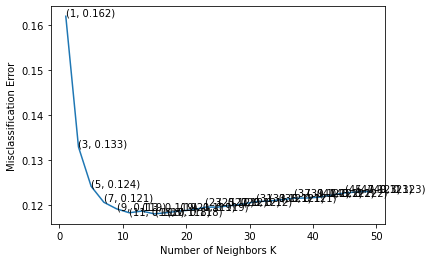

the misclassification error for each k value is :  [0.162 0.133 0.124 0.121 0.119 0.118 0.119 0.118 0.118 0.119 0.119 0.12
 0.12  0.12  0.12  0.121 0.121 0.121 0.122 0.122 0.122 0.122 0.123 0.123
 0.123]


In [22]:
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
cv_scores = []
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train,y_train, cv=3, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

In [25]:
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)
# fitting the model
knn_optimal.fit(X_train,y_train)
# predict the response
pred = knn_optimal.predict(X_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k,acc))


The accuracy of the knn classifier for k = 15 is 88.293333%


In [30]:
confusion_matrix(y_test,pred)

array([[ 1685,  3056],
       [  456, 24803]], dtype=int64)